# Test the HALO Downstreaming Pipelines

## Load the library

In [1]:
# import scvi
from typing import Dict, Iterable, Optional
# import scvi
import numpy as np
import torch
import pandas as pd
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from models import HALOMASKVIR as HALOVI
from models import HALOMASKVAE as HALOVAE

import scanpy as sc
import scvi
from matplotlib import pyplot as plt

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [2]:
path2figdir = "figs/Hair/20_aligned"
sc.settings.figdir =path2figdir
sc.set_figure_params(vector_friendly=True)

In [3]:
path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [4]:
HALOVI.setup_anndata(adata_mvi,time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)     

self.w_a :1
yes there is aligner


## Load pretrained model

In [5]:
model = model.load("model_hair_align_causal01_20", adata_mvi)


INFO     File model_hair_align_causal01_20/model.pt already downloaded                       
self.w_a :1
yes there is aligner


In [6]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [7]:
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)

In [8]:
adata_mvi.obs.loc[(adata_mvi.obs.celltype=="TAC-2")&(adata_mvi.obs.latent_time>0.45), "celltype"] = "IRS"

adata_mvi.obs.celltype.unique()

['TAC-1', 'IRS', 'Medulla', 'TAC-2', 'Hair Shaft-cuticle.cortex']
Categories (5, object): ['Hair Shaft-cuticle.cortex', 'IRS', 'Medulla', 'TAC-1', 'TAC-2']

## Visualize the representations

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


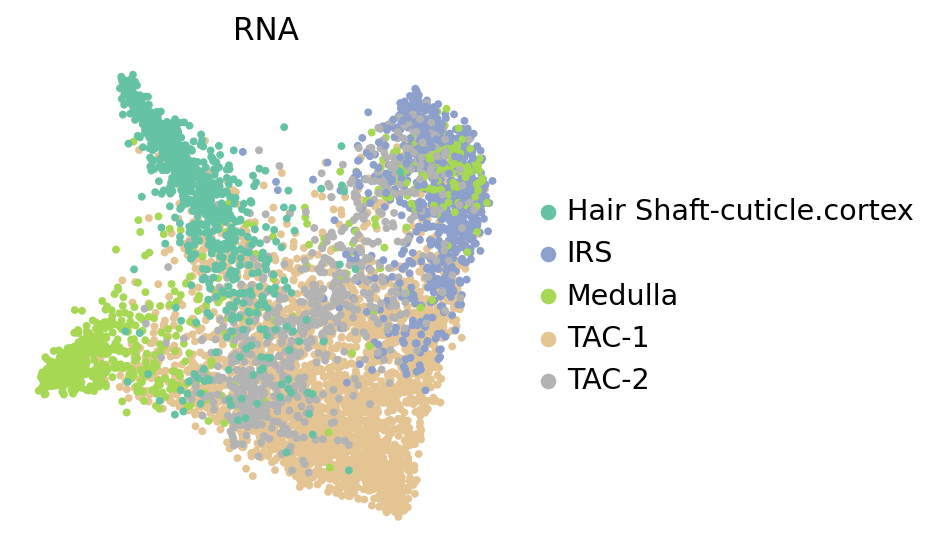

<Figure size 320x320 with 0 Axes>

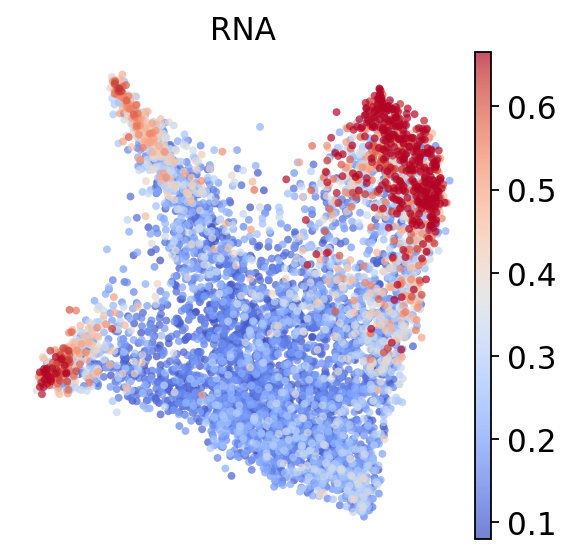

<Figure size 320x320 with 0 Axes>

In [91]:
adata_mvi.obsm["latent"] = latent_expr

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.01, negative_sample_rate=0.05, spread=10)

# sc.pl.umap(rna_data, frameon=False, size = 10, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color='leiden')
from matplotlib import pyplot as plt

path2figdir = "figs/Hair/20_aligned/"
sc.settings.figdir =path2figdir
figure_name = "_RNA"
format = ".png"
save_path = figure_name+format
# with plt.rc_context():
sc.set_figure_params(vector_friendly=True)
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=False,
        outline_width=(0.01,0), color=['celltype'], title="RNA",save=save_path, palette="Set2")
plt.savefig(save_path, bbox_inches="tight", dpi=300)      



figure_name = "_RNA_latenttime"
format = ".png"
save_path = figure_name+format

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=['latent_time'], title="RNA", color_map = 'coolwarm', save=save_path, vmin="p05", vmax="p95") 

plt.savefig(save_path, bbox_inches="tight", dpi=300)      

## Visualize the decouple ATAC representations

In [9]:
adata_mvi.obsm["latent"] = latent_atac_indep

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=10, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1)
sc.tl.leiden(adata_mvi)
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1, spread=10)


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


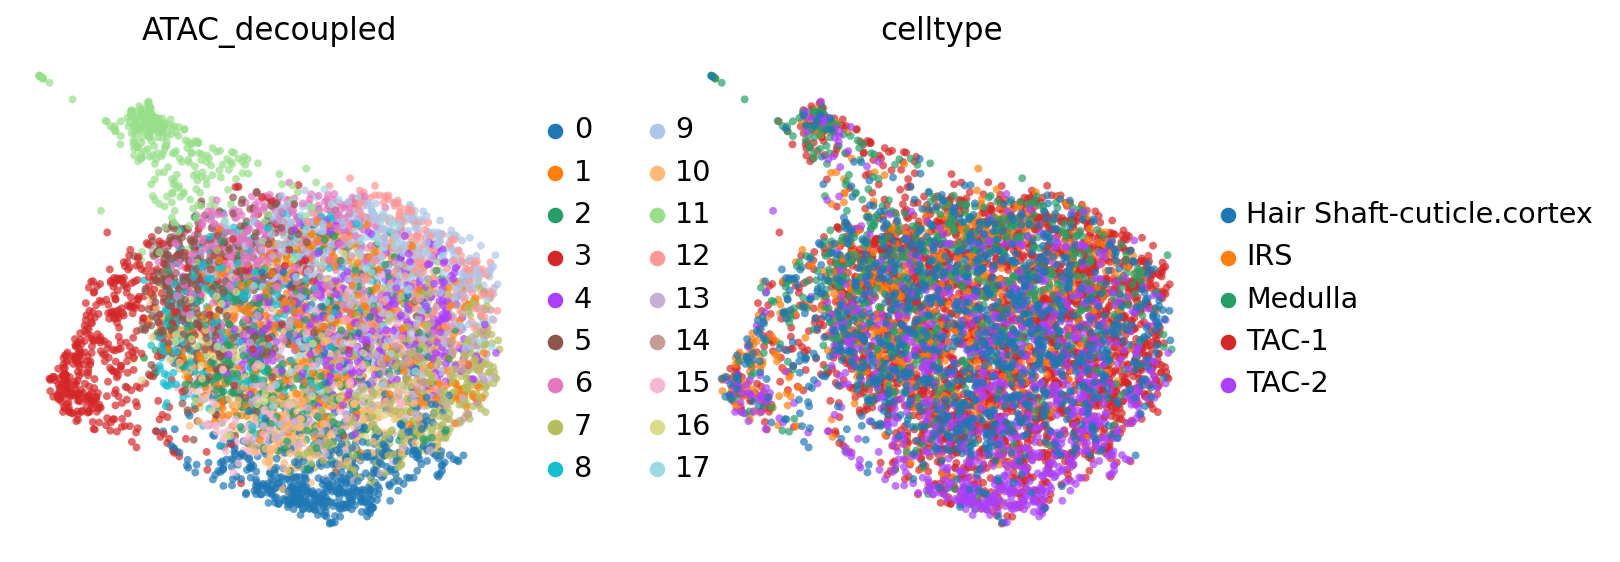

In [13]:
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=['leiden', "celltype"], title="ATAC_decoupled", color_map = 'coolwarm', vmin="p05", vmax="p95", save="decouple_atac_leiden.pdf") 

## Visualize the contacnated representations of RNA and ATAC

In [49]:
adata_mvi.obsm["latent"] = np.concatenate([latent_expr, latent_acc], axis=1)
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=50, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1, spread=10)
# sc.tl.leiden(adata_mvi)


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


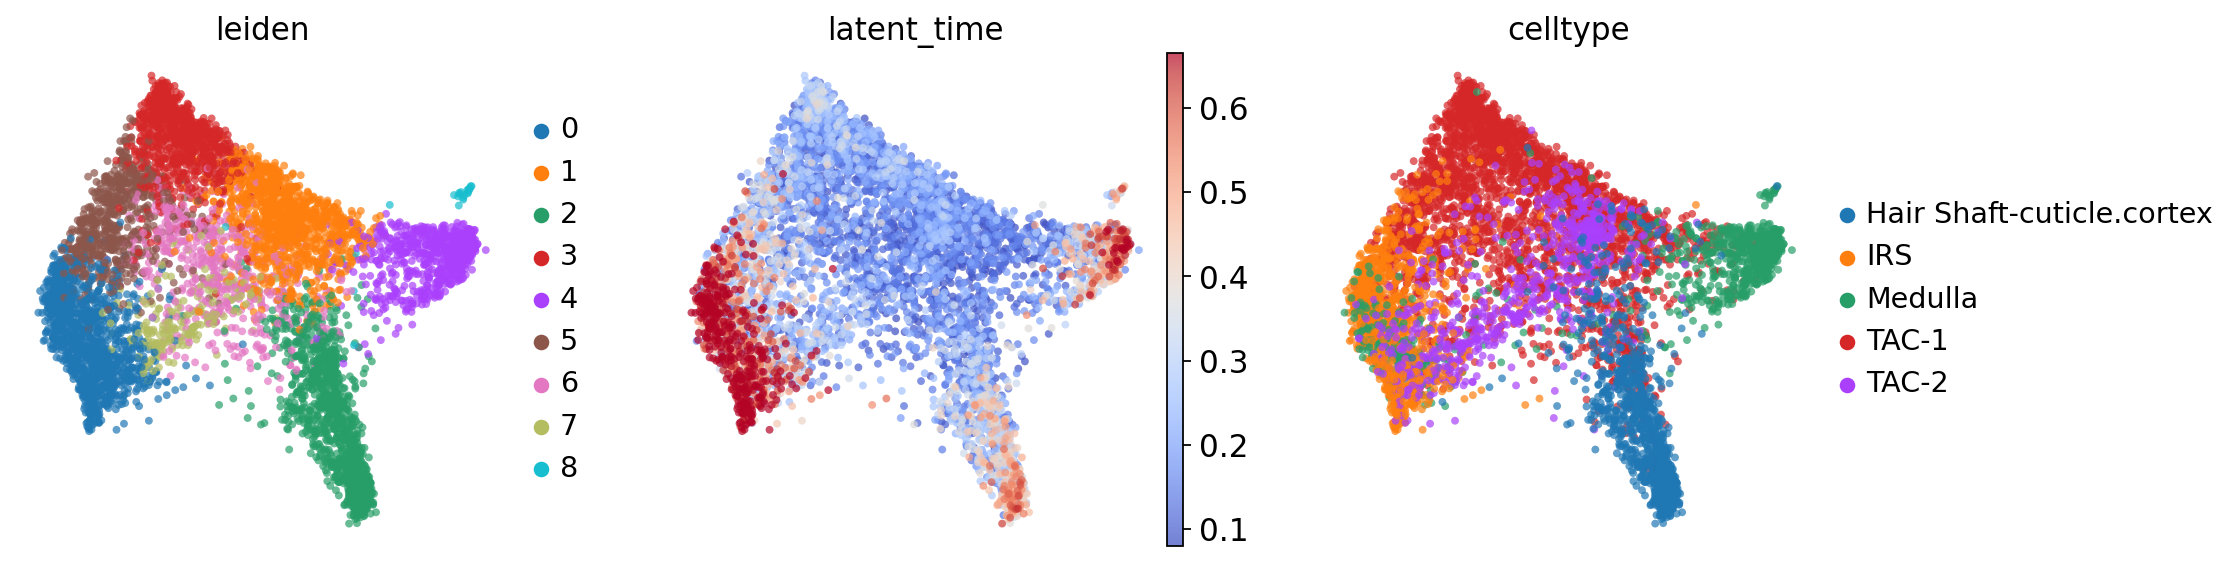

In [211]:
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=[ "leiden", "latent_time", "celltype"],  color_map = 'coolwarm', vmax="p95", vmin="p05") 

In [13]:
for i in range(20):
    adata_mvi.obs["epxr_latent_"+str(i)] = latent_expr[:,i]

for i in range(20):
    adata_mvi.obs["atac_latent_"+str(i)] =  latent_acc[:,i]

In [36]:
import seaborn as sns

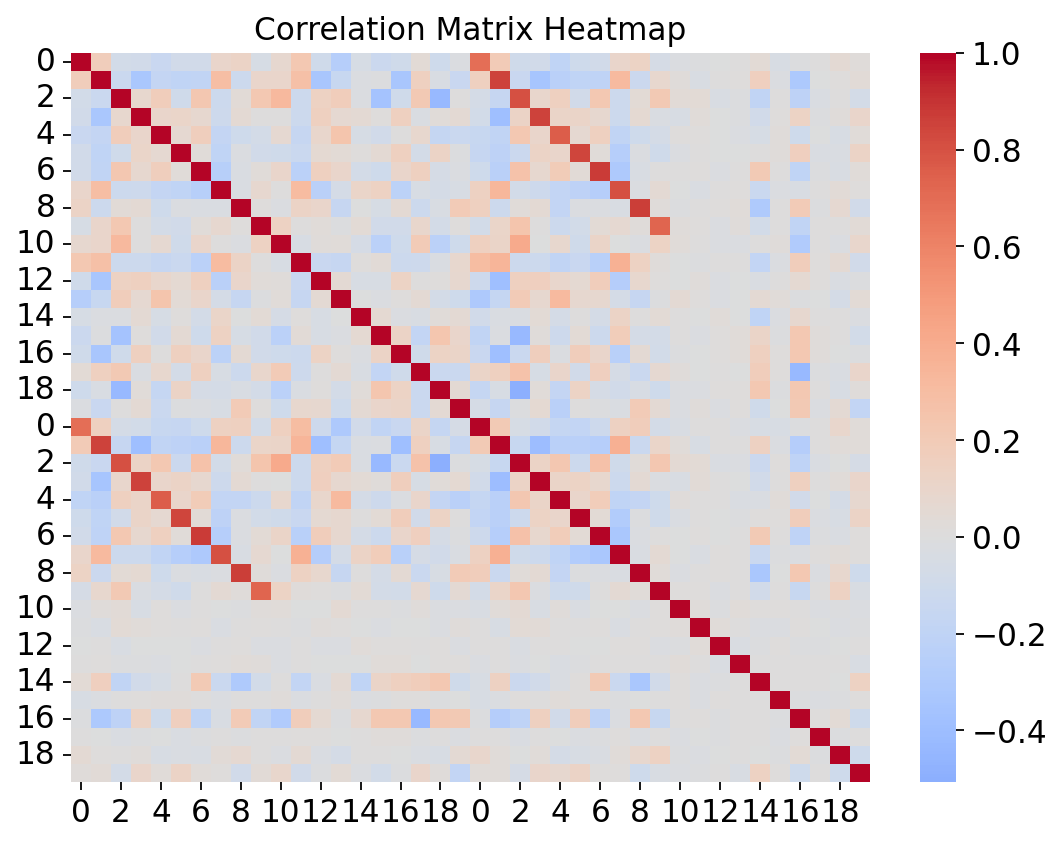

In [377]:
df_A = pd.DataFrame(latent_expr)
df_B = pd.DataFrame(latent_acc)
df_combined = pd.concat([df_A, df_B], axis=1)
correlation_matrix = df_combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", center=0.0)
plt.title('Correlation Matrix Heatmap')
plt.savefig("figs/Hair/20_aligned/mouse_latent_corr.png", dpi=300)
plt.show()

In [21]:
for i in range(20):
        latent_name = "atac_latent_"+str(i) 

        path2figdir = "figs/Hair/20_aligned/"
        sc.settings.figdir =path2figdir
        figure_name = latent_name + "_both_"
        format = ".png"
        save_path = figure_name+format
        sc.set_figure_params(vector_friendly=True)
        sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.5, add_outline=True, outline_color=("lightgray", "white"), 
        outline_width=(0.3,0), color=[latent_name], title=latent_name, color_map = 'Blues', save=save_path, vmin="p25", vmax="p95",show=False)
        plt.close()      



In [11]:
from complementary_models import split_rna,split_atac
rna_data = sc.read_h5ad("data/datasets/mouse_hair_rna_paired.h5ad")
atac_data = sc.read_h5ad("data/datasets/mouse_hair_mira_atac_norm.h5ad")
# adata_mvi = sc.read_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")

In [9]:
rna_data.obsm["latent"] = latent_atac_indep
sc.pp.neighbors(rna_data, use_rep = 'latent',n_neighbors=30, metric = 'manhattan')
sc.tl.leiden(rna_data)
sc.tl.umap(rna_data, min_dist=0.1, negative_sample_rate=0.1, spread=10)

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7fb42f5d4040>
Traceback (most recent call last):
  File "/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [125]:
adata_mvi.obsm["latent"] = latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=30, metric = 'manhattan')
sc.tl.leiden(adata_mvi)
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1, spread=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


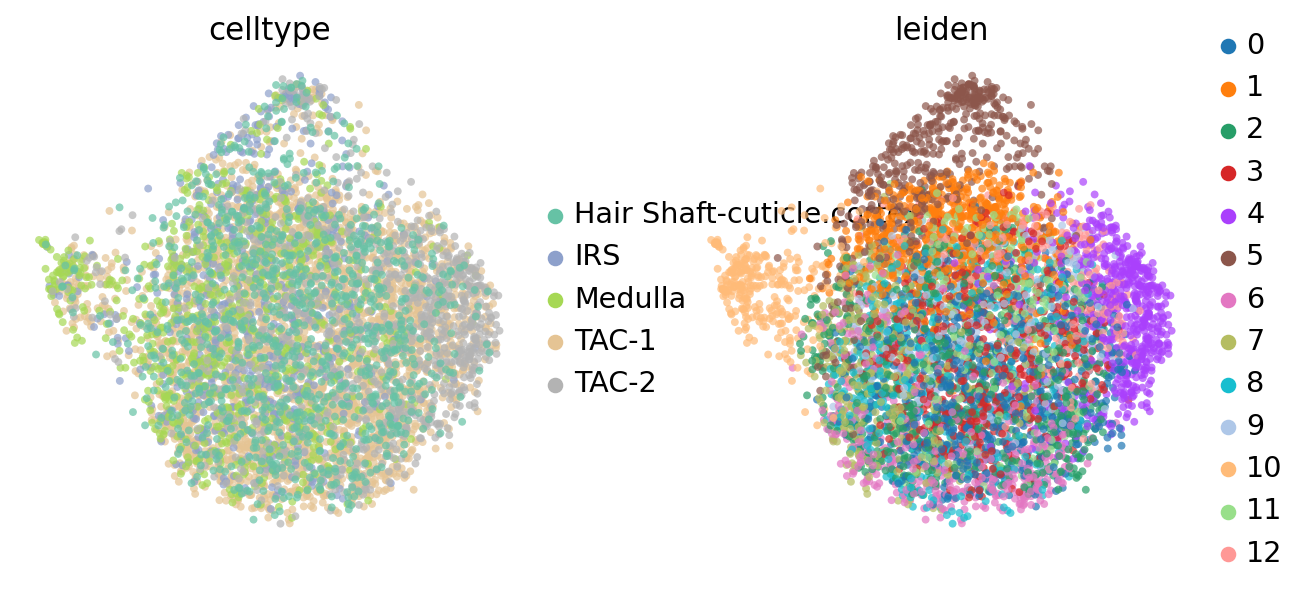

In [48]:

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=["celltype", "leiden"], color_map = 'coolwarm', vmin="p05", vmax="p95", use_raw=False)         

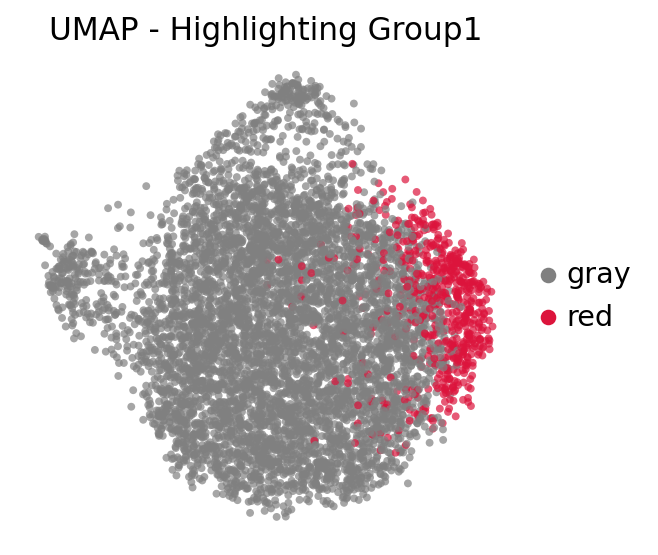

In [81]:
custom_palette = {
    'red': 'crimson',  # Color for the group of interest
    'gray': 'gray'   # Default color for all other groups
}
atac_data.obs['color_group'] = 'gray'

# Now, for cells belonging to the group of interest, set a different color
# For example, setting 'Group1' to be colored 'red'
atac_data.obs.loc[atac_data.obs['leiden'] == '4', 'color_group'] = 'red'

sc.pl.umap(atac_data, color='color_group', title='UMAP - Highlighting Group1', palette=custom_palette, size = 50, alpha = 0.7, add_outline=False, frameon=False,
        outline_width=(0.1,0))        

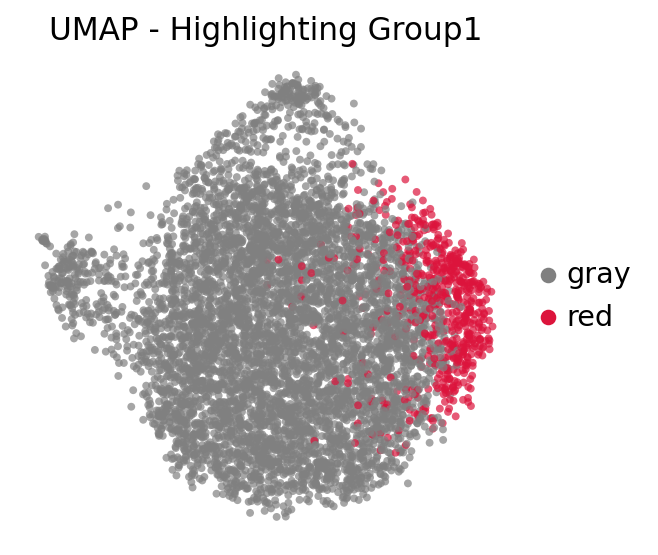

In [87]:
custom_palette = {
    'red': 'crimson',  # Color for the group of interest
    'gray': 'gray'   # Default color for all other groups
}
adata_mvi.obs['color_group'] = 'gray'

# Now, for cells belonging to the group of interest, set a different color
# For example, setting 'Group1' to be colored 'red'
adata_mvi.obs.loc[adata_mvi.obs['leiden'] == '4', 'color_group'] = 'red'

sc.pl.umap(adata_mvi, color='color_group', title='UMAP - Highlighting Group1', palette=custom_palette, size = 50, alpha = 0.7, add_outline=False, frameon=False,
        outline_width=(0.1,0))       

In [98]:
cluster2annotation = {
    "red": "novel roots",
    "gray": "expected roots"}

marker_genes_dict = {
    "novel roots": ["Lef1", "Dach1", "Cdh6", "Scube2"],
    "expected roots": ["Cux1","Efna5", "Robo1"],
}

/tmp/ipykernel_22614/1769321309.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mvi_sub.obs["cell sub type"] = adata_mvi_sub.obs["color_group"].map(cluster2annotation).astype("category")


<Figure size 3000x3000 with 0 Axes>

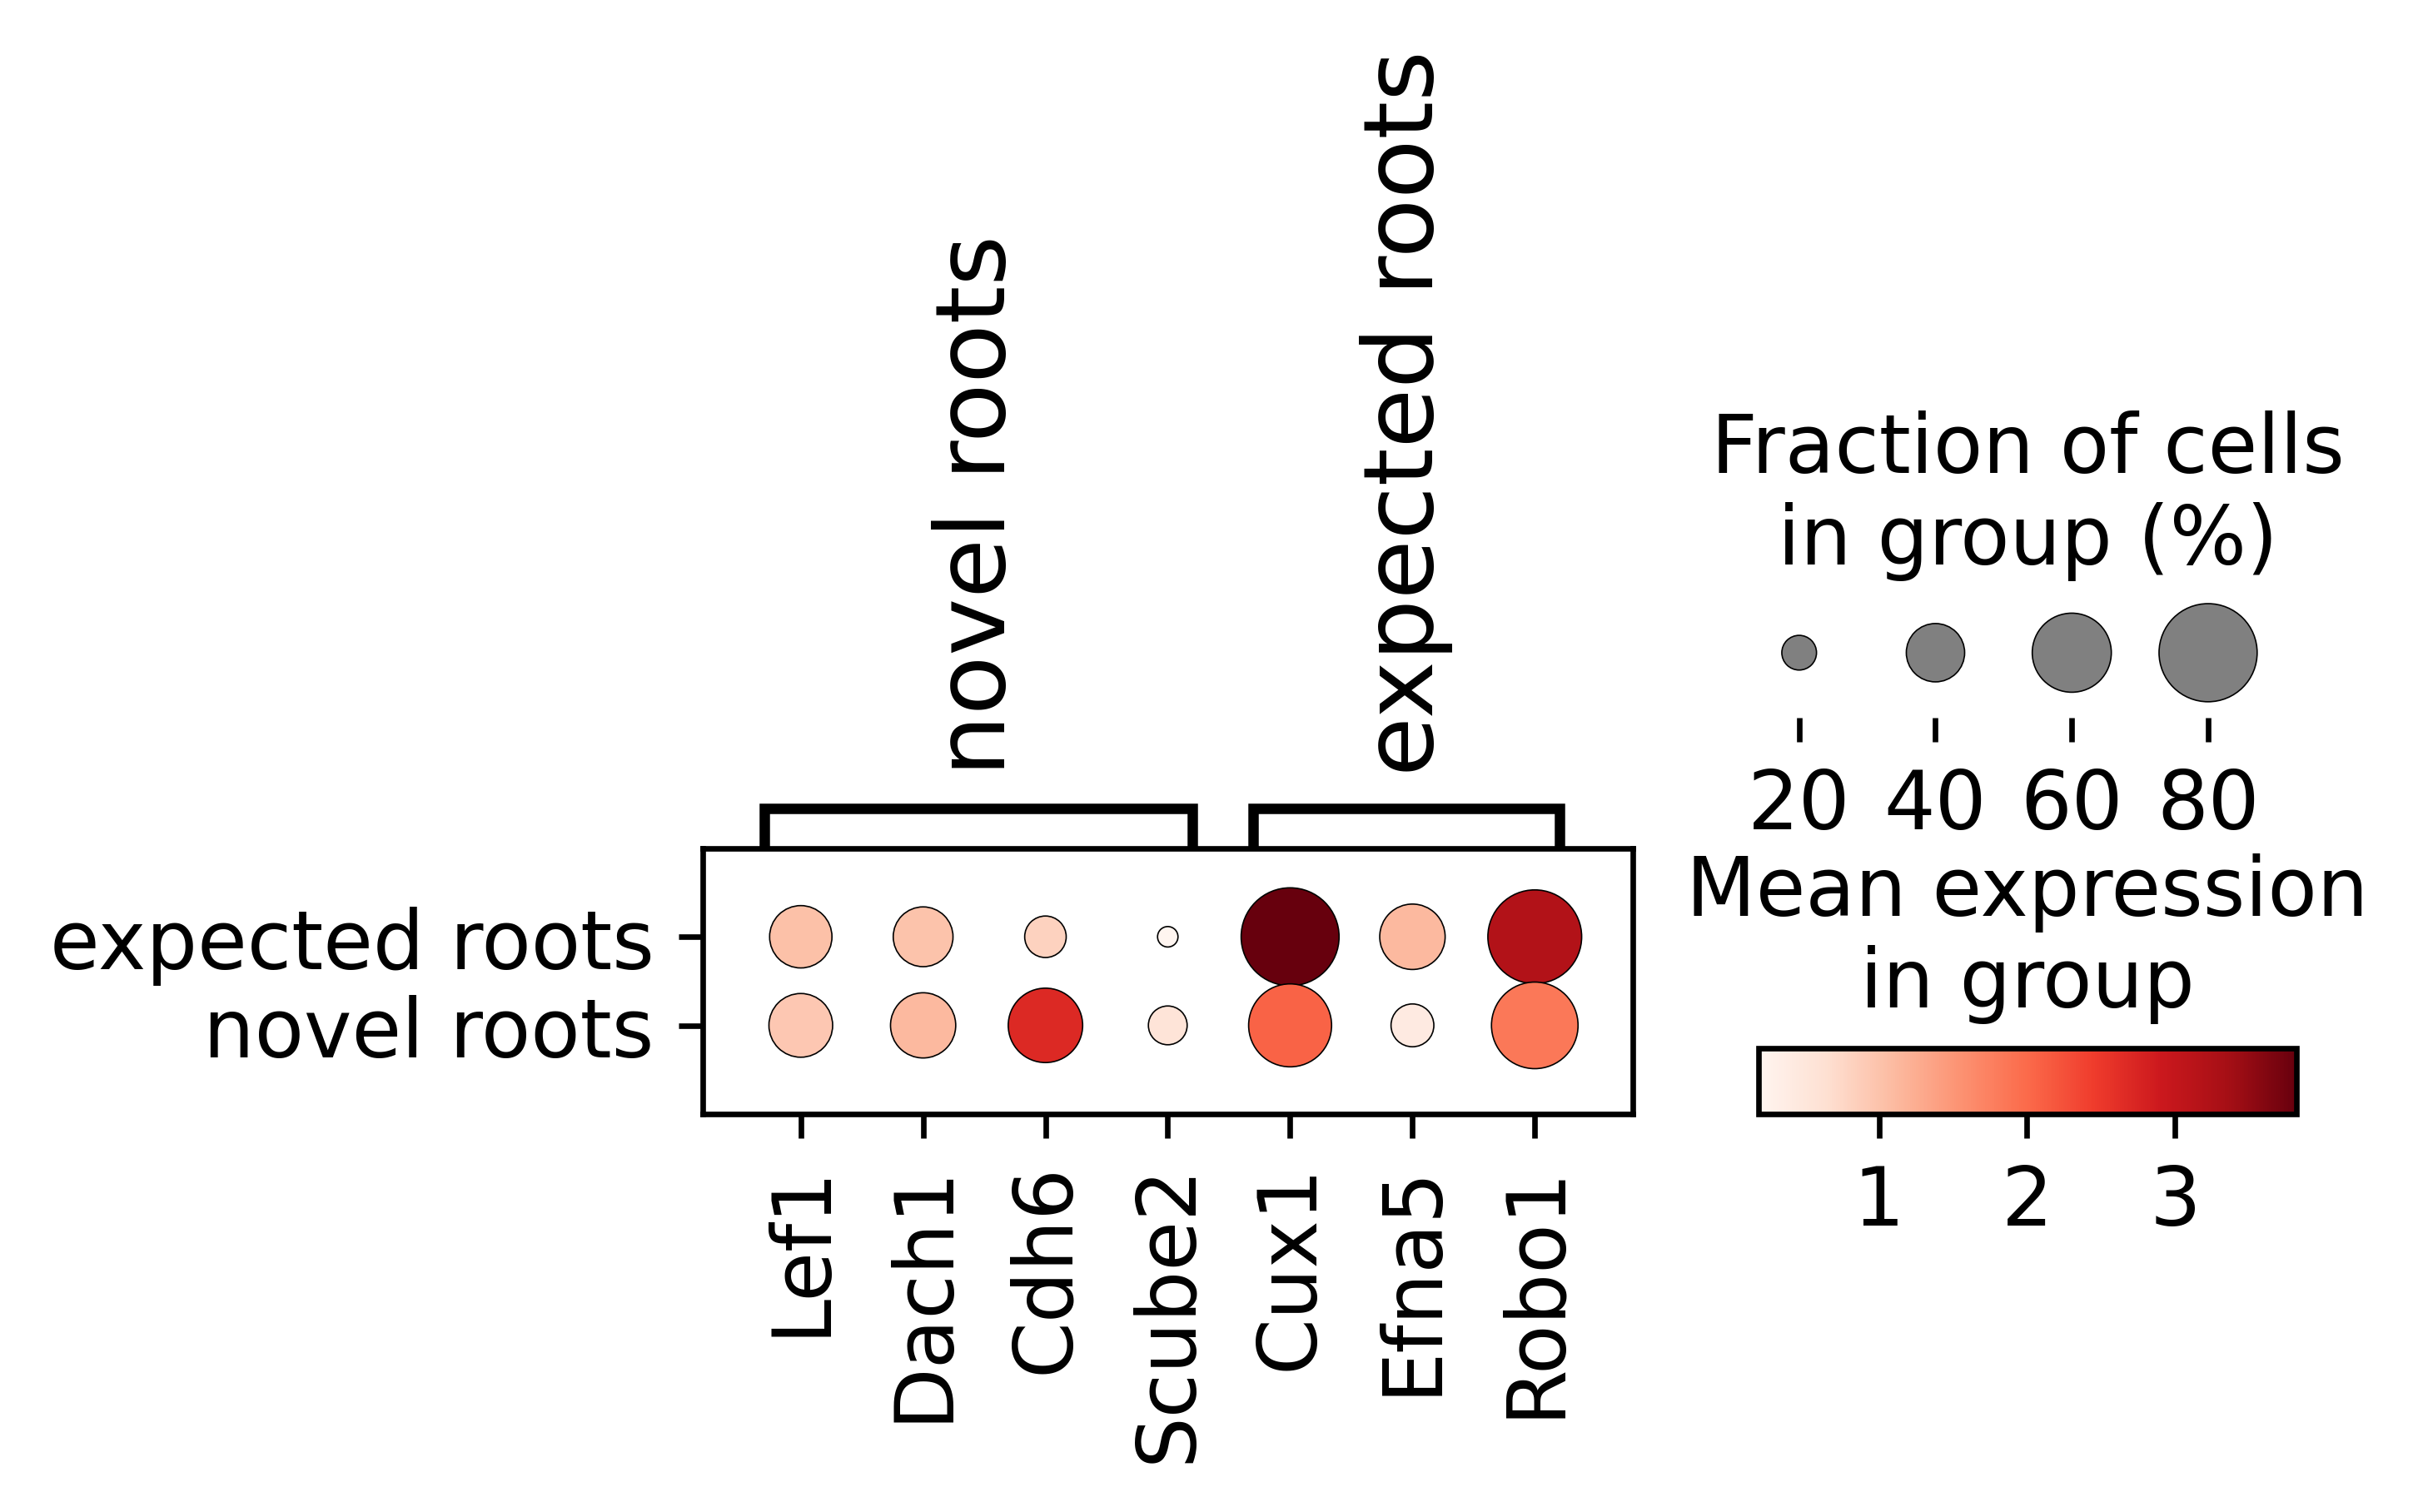

In [99]:
adata_mvi_sub.obs["cell sub type"] = adata_mvi_sub.obs["color_group"].map(cluster2annotation).astype("category")
sc.set_figure_params(scanpy=True, dpi=300, dpi_save=500, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf',
                         facecolor=None, transparent=False, ipython_format='png2x')
plt.figure(figsize=[10,10])
# sc.pl.dotplot(adata_mvi_sub,marker_genes_dict, groupby="cell sub type", save="roots_subtypes.pdf")
sc.pl.dotplot(adata_mvi_sub,marker_genes_dict, groupby="cell sub type")

## Get highly expressed peaks for each representation and loading matrix

In [23]:
atac_data = sc.read_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [24]:
loadings = model.get_atac_loading()
loadings.shape

(112656, 20)

In [25]:
loadings = loadings.T

## TF enrichment analysis

In [32]:
import matplotlib.pyplot as plt

def compare_latent_TFs(l1=0, l2=18 ,save_path=None, pval_threshold=(1e-20, 1e-20)):
    latent_l1_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=l1, top_quantile=1e-5, loadings=loadings, num_exo_features=1e6)
    latent_l2_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=l2, top_quantile=1e-5, loadings=loadings, num_exo_features=1e6)
    model.plot_compare_topic_enrichments(l1, l2, pval_threshold=pval_threshold, color="darkorchid")
    if save_path!=None:
        plt.savefig(save_path, dpi=300)



Finding enrichments:   0%|          | 0/107 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/107 [00:00<?, ?it/s]

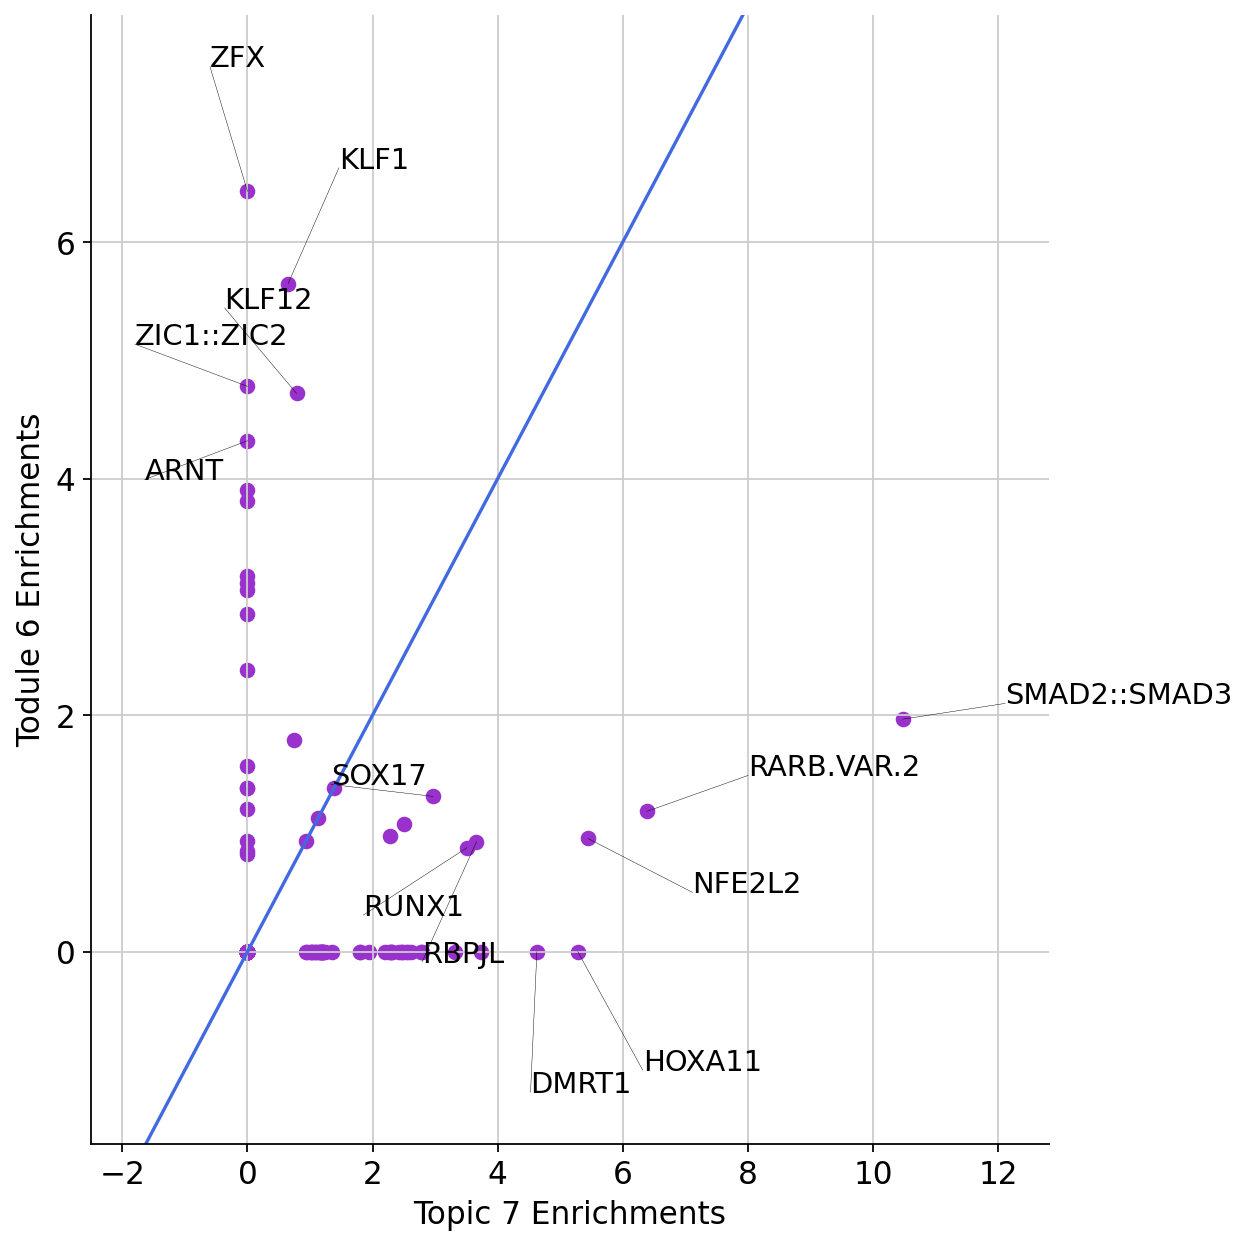

In [210]:
compare_latent_TFs(7,6, "figs/Hair/20_aligned/TF_7_6.png",pval_threshold=(1e-4, 1e-4))

In [19]:


def compare_couple_decouple_latent_TFs(atac_data,  loadings, pval_threshold=[1e-5, 1e-5],save_path=None):
    latent_l1_tf, index_learnt = model.get_enriched_grouped_TFs(atac_data, group_index=range(10, 20), top_quantile=2e-5, loadings=loadings, num_exo_features=1e6,group_type="decoupled")
    latent_l2_tf, index_learnt = model.get_enriched_grouped_TFs(atac_data, group_index=range(10), top_quantile=2e-5, loadings=loadings, num_exo_features=1e6, group_type="coupled")
    model.plot_compare_group_enrichments(factor_type = 'motifs', color = 'crimson', pval_threshold=pval_threshold)
    if save_path!= None:
        plt.savefig(save_path, dpi=300)


In [20]:
from complementary_models import split_atac
atac_data = split_atac(adata_mvi)

Finding enrichments:   0%|          | 0/107 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/107 [00:00<?, ?it/s]

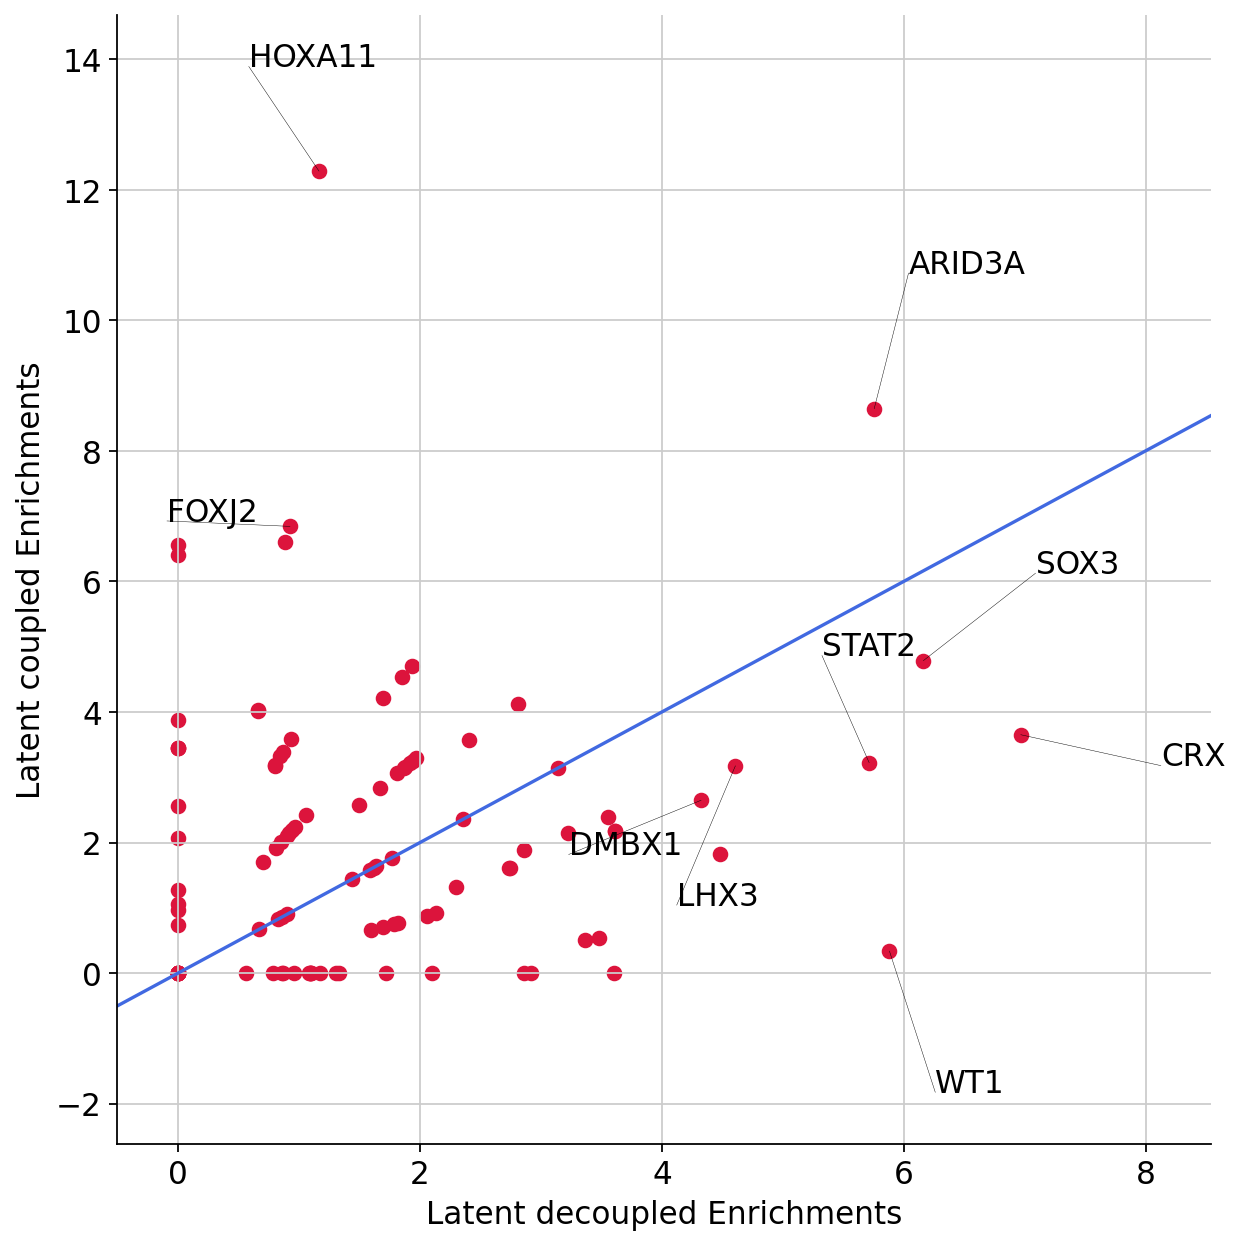

In [200]:

compare_couple_decouple_latent_TFs(atac_data,  loadings, pval_threshold = (1e-6, 1e-8), save_path="figs/Hair/20_aligned/TF_quant2_labeled.png")